In [1]:
%matplotlib notebook

# %qtconsole

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes

# Imports

# Init

## Init instruments and station

In [2]:
%run -i D:/OneDrive/BF2/Code/BF2/BF2/init_station_cqed.py

Connected to: TEKTRONIX AWG5208 (serial:B020237, firmware:FV:6.1.0054.0) in 0.67s


In [32]:
def simple_alazar_setup_ext_trigger(nsamples, nrecords, nbuffers, 
                                    allocated_buffers=2, 
                                    SR=1e8, int_time=None):
    """
    Simple setting up of the alazar. This is basically just setting some
    reasonable starting values when starting up the station.
    Parameters:
    -----------
    nsamples : int
        samples per record
    nrecords : int
        records per buffer
    nbuffers : int
        buffers per acquisition
    allocated_buffers : int (default: 2)
        allocated buffers
    SR : float (default: 1e8)
        sampling rate
    int_time : float (default: None)
        if not None, will try to compute number of samples that best corresponds
        to this measurement time (taking mod 128 into account, and that we need at
        least 256 samples per record). Overrrides nsamples if set.
    """
    
    alazar = qc.Instrument.find_instrument('alazar')
    idn = alazar.get_idn()
    
    SR = int(SR)
    if int_time is not None:
        SPR = max(256, int(int_time * SR // 128 * 128))
    else: 
        SPR = nsamples
    
    with alazar.syncing():
        alazar.clock_source('INTERNAL_CLOCK')
        alazar.sample_rate(SR)
        alazar.clock_edge('CLOCK_EDGE_RISING')

        if idn['model'] == 'ATS9870':
            alazar.external_sample_rate(int(1e9))

        alazar.decimation(1)
        alazar.coupling1('DC')
        alazar.coupling2('DC')

        if idn['model'] == 'ATS9870':
            crange = 0.1
        elif idn['model'] in ['ATS9360', 'ATS9373']:
            crange = 0.4
        else:
            raise ValueError("Don't know model", idn['model'])
        alazar.channel_range1(crange)
        alazar.channel_range2(crange)
        
        alazar.impedance1(50)
        alazar.impedance2(50)
        alazar.trigger_source1('EXTERNAL')
        alazar.trigger_level1(128 + 5)
        alazar.external_trigger_coupling('DC')
        
        if idn['model'] == 'ATS9870':
            trange = 'ETR_5V'
        elif idn['model'] in ['ATS9360', 'ATS9373']:
            trange = 'ETR_2V5'
        else:
            raise ValueError("Don't know model", idn['model'])
        alazar.external_trigger_range(trange)
        
        alazar.trigger_delay(0)
        # alazar.timeout_ticks(int(1e7))
        alazar.timeout_ticks(int(0))
        alazar.records_per_buffer(nrecords)
        alazar.buffers_per_acquisition(nbuffers)
        alazar.buffer_timeout(10000)
        alazar.samples_per_record(SPR)
        alazar.allocated_buffers(allocated_buffers)
    
simple_alazar_setup_ext_trigger(1024, 1, 1)

# Test sequence

In [8]:
from cqed import bb_sequences; reload(bb_sequences)
from cqed.bb_sequences import TriggeredReadoutSequence

TriggeredReadoutSequence.chan_map = {
    1 : ['debug_pulse', 'ro_trigger', None]
}

trig_seq = create_inst(TriggeredReadoutSequence, name='trigger_seq', awg=station.awg, force_new_instance=True)
trig_seq.setup()

No ro_gate defined in channel map. No readout gate pulse will be generated.
No src_gate defined in channel map. No src gate pulse will be generated.


Instrument trigger_seq already exists.
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


# Load acquisition controllers

In [155]:
from pytopo.rf import alazar_acquisition, alazar_detector
reload(alazar_acquisition); reload(alazar_detector)

raw_acq = create_inst(alazar_acquisition.RawAcqCtl, 
                      'raw_acq', 'alazar', force_new_instance=True)
raw_det = create_inst(alazar_detector.AlazarDetector, 
                      'raw_det', raw_acq, force_new_instance=True)

avg_demod_acq = create_inst(alazar_acquisition.AvgDemodCtl, 
                            'avg_demod_acq', 'alazar', force_new_instance=True)
avg_demod_det = create_inst(alazar_detector.AlazarDetector, 
                            'avg_demod_det', avg_demod_acq, force_new_instance=True)

demod_acq = create_inst(alazar_acquisition.DemodCtl, 
                        'demod_acq', 'alazar', force_new_instance=True)
demod_det = create_inst(alazar_detector.AlazarDetector, 
                        'demod_det', demod_acq, sweep_params=[],
                        force_new_instance=True,)

Instrument raw_acq already exists.
Instrument raw_det already exists.
Instrument avg_demod_acq already exists.
Instrument avg_demod_det already exists.
Instrument demod_acq already exists.
Instrument demod_det already exists.


# Raw acquisition

In [180]:
raw_det.set_sweeper(trig_seq)
raw_det.avg_buffers(False)
raw_det.acq_time(5e-6)

raw_det.configure_alazar(
    buffers_per_acquisition=2,
    records_per_buffer=1,
)

raw_det.setup()

In [181]:
trig_seq.sweep_dims, trig_seq.sweep_shape, raw_det.sweep_dims, raw_det.sweep_shape

(['awg_sweep_idx'],
 (1,),
 ['awg_sweep_idx', 'samples', 'channels'],
 (1, 512, 2))

In [182]:
data = raw_det.acquisition()
tvals = raw_acq.tvals
data.shape, raw_det.sweep_dims, raw_det.sweep_shape

((2, 1, 512, 2), ['awg_sweep_idx', 'samples', 'channels'], (1, 512, 2))

<IPython.core.display.Javascript object>


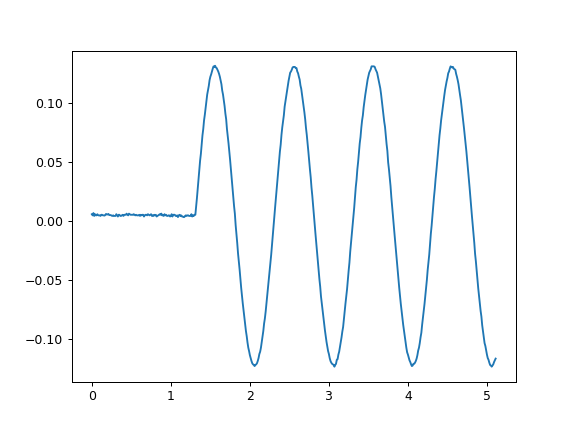

In [183]:
fig, ax = plt.subplots(1,1)
ax.plot(tvals * 1e6, data[0, 0, :, 0])

# Demod acquisition (no buffer avg)

In [163]:
acq = demod_acq
det = demod_det

det.set_sweeper(trig_seq)
det.avg_buffers(False)
det.acq_time(5e-6)
det.demod_frq(1e6)

det.configure_alazar(
    buffers_per_acquisition=2,
    records_per_buffer=1,
)

det.setup()

In [164]:
trig_seq.sweep_dims, trig_seq.sweep_shape, det.sweep_dims, det.sweep_shape

(['awg_sweep_idx'],
 (1,),
 ['awg_sweep_idx', 'buffers', 'records', 'IF_periods', 'channels'],
 (1, 1, 1, 1, 1))

In [165]:
data = det.acquisition()
tvals = acq.demod_tvals
data.shape

(2, 1, 5, 2)

In [166]:
det.sweep_dims, det.sweep_shape

(['awg_sweep_idx', 'buffers', 'records', 'IF_periods', 'channels'],
 (1, 2, 1, 5, 2))

In [167]:
det.inner_dims

['buffers', 'records', 'IF_periods', 'channels']

<IPython.core.display.Javascript object>


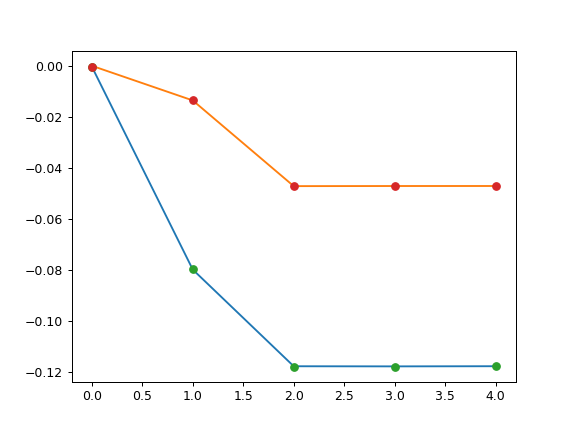

In [168]:
fig, ax = plt.subplots(1,1)
ax.plot(tvals * 1e6, data[0, 0, :, 0].real)
ax.plot(tvals * 1e6, data[0, 0, :, 0].imag)

ax.plot(tvals * 1e6, data[1, 0, :, 0].real, 'o')
ax.plot(tvals * 1e6, data[1, 0, :, 0].imag, 'o')

In [169]:
det.get_all()

[(<qcodes.instrument.parameter.Parameter: awg_sweep_idx at 2163263590072>,
  array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.])),
 (<qcodes.instrument.parameter.Parameter: buffers at 2163295402584>,
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.])),
 (<qcodes.instrument.parameter.Parameter: records at 2163295402752>,
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.])),
 (<qcodes.instrument.parameter.Parameter: IF_periods at 2163295402864>,
  array([ 0.,  0.,  1.,  1.,  2.,  2.,  3.,  3.,  4.,  4.,  0.,  0.,  1.,
          1.,  2.,  2.,  3.,  3.,  4.,  4.])),
 (<qcodes.instrument.parameter.Parameter: channels at 2163295402976>,
  array([ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
          1.,  0.,  1.,  0.,  1.,  0.,  1.])),
 (<qcodes.instrument.parameter.Parameter

# Demod acquisition (with buffer average)

In [170]:
acq = avg_demod_acq
det = avg_demod_det

det.set_sweeper(trig_seq)
det.avg_buffers(False)
det.acq_time(5e-6)
det.demod_frq(1e6)

det.configure_alazar(
    buffers_per_acquisition=2,
    records_per_buffer=1,
)

det.setup()

In [171]:
trig_seq.sweep_dims, trig_seq.sweep_shape, det.sweep_dims, det.sweep_shape

(['awg_sweep_idx'],
 (1,),
 ['awg_sweep_idx', 'IF_periods', 'channels'],
 (1, 1, 1))

In [101]:
data = det.acquisition()
tvals = acq.demod_tvals
data.shape

(1, 5, 2)

<IPython.core.display.Javascript object>


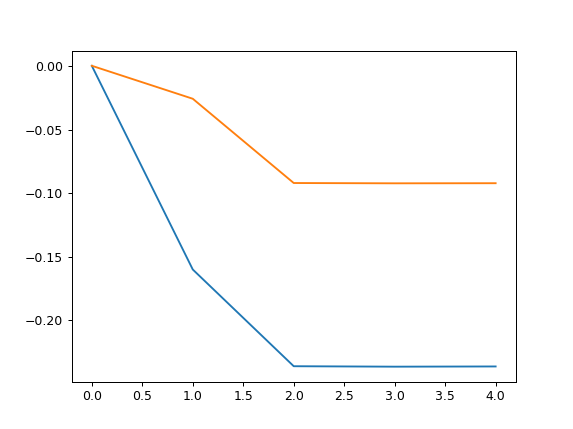

In [102]:
fig, ax = plt.subplots(1,1)
ax.plot(tvals * 1e6, data[0, :, 0].real)
ax.plot(tvals * 1e6, data[0, :, 0].imag)